In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
martabase = pd.read_csv("martabase_final.csv")

In [3]:
martabase

,ID,Station,Latitude,Longitude,Color
0,1,Airport,33.640758,-84.446341,NaN
1,2,Arts Center,33.789705,-84.387789,NaN
2,3,Ashby,33.756346,-84.417556,NaN
3,4,Avondale,33.775277,-84.281903,NaN
4,5,Bankhead,33.771890,-84.428840,NaN
...,...,...,...,...,...
155,156,Standing Peachtree Park,33.830141,-84.445858,NaN
156,157,Kennedy Memorial Gardens,33.677714,-84.289007,NaN
157,158,Chapel Hill Park,33.673422,-84.225972,NaN
158,159,Collins Hill Park,34.017629,-84.014661,NaN


In [4]:
martabase.shape

(160, 5)

In [5]:
import folium

mapmarta=folium.Map(location=[33.934150, -84.246706])

for ind in range(len(martabase["Station"])):
    name = martabase.iloc[ind,1]
    lat = martabase.iloc[ind,2]
    longi = martabase.iloc[ind,3]
    folium.Marker([lat,longi],tooltip=name, icon=folium.Icon(color='black',icon_color='red')).add_to(mapmarta)
mapmarta

In [6]:
from collections import defaultdict

class Graph:
    def __init__(self, vertices):
        self.V = vertices
        self.graph = defaultdict(list)

    def addEdge(self, v1, v2):
        self.graph[v1].append(v2)
        self.graph[v2].append(v1)

    def DepthFirst(self, v, visited_list):
        visited_list[v] = True
        for i in self.graph[v]:
            if visited_list[i] == False:
                self.DepthFirst(i, visited_list)
    
    def isConnected(self):
        visited_list = False*(self.V)
        for i in range(self.V):
            if(len(self.graph[i]) != 0):
                break
        if i == self.V-1:
            return True
       
        self.DepthFirst(i, visited_list)
 
        # Check if all non-zero degree vertices are visited
        for i in range(self.V):
            if visited_list[i] == False and len(self.graph[i]) > 0:
                return False
 
        return True
    
    def isEulerian(self):
        # Check if all non-zero degree vertices are connected
        if self.isConnected() == False:
            return 0
        else:
            # Count vertices with odd degree
            odd = 0
            for i in range(self.V):
                if len(self.graph[i]) % 2 != 0:
                    odd += 1
            #number of odds:
                # 0 -> euler cycle
                # 2 -> euler path 
                # >2 -> not eulerian 
            if odd == 0:
                return 2 #euler cycle
            elif odd == 2:
                return 1 #euler path
            elif odd > 2:
                return 0 #no euler
    
    def test(self):
        res = self.isEulerian()
        if res == 0:
            print("Graph is not Eulerian")
        elif res == 1:
            print("Graph has a Euler path")
        else:
            print("Graph has a Euler cycle")

In [7]:
g = Graph(160)
g.addEdge(1,2)

In [8]:
names = martabase.iloc[:,1]
latitudes = martabase.iloc[:,2]
longitudes = martabase.iloc[:,3]
longitudes

0     -84.446341
1     -84.387789
2     -84.417556
3     -84.281903
4     -84.428840
         ...    
155   -84.445858
156   -84.289007
157   -84.225972
158   -84.014661
159   -84.510412
Name: Longitude, Length: 160, dtype: float64

In [9]:
npnames = names.to_numpy()
nplats = latitudes.to_numpy()
nplongs = longitudes.to_numpy()

In [10]:
from sklearn.preprocessing import MinMaxScaler

nplats = nplats.reshape(-1, 1)
nplongs = nplongs.reshape(-1, 1)

lats_fin = MinMaxScaler().fit_transform(nplats)
longs_fin = MinMaxScaler().fit_transform(nplongs)

In [11]:
lats_fin

array([[0.06162806],
       [0.30460848],
       [0.25018923],
       [0.28107178],
       [0.27554649],
       [0.4204323 ],
       [0.4003752 ],
       [0.46349103],
       [0.26643556],
       [0.07943393],
       [0.28015824],
       [0.25010277],
       [0.48792659],
       [0.51911909],
       [0.26457749],
       [0.1220783 ],
       [0.25941436],
       [0.2460783 ],
       [0.23632137],
       [0.24071615],
       [0.24740294],
       [0.27212724],
       [0.25206688],
       [0.27680914],
       [0.23976998],
       [0.15901631],
       [0.39830995],
       [0.35728385],
       [0.50197227],
       [0.29060522],
       [0.27525612],
       [0.5572137 ],
       [0.1857553 ],
       [0.25562316],
       [0.53842577],
       [0.25104405],
       [0.21668842],
       [0.24495922],
       [0.76027732],
       [0.53130669],
       [0.84556281],
       [0.61658564],
       [0.68632137],
       [0.74995269],
       [0.69017945],
       [0.87550408],
       [0.79616313],
       [0.787

In [12]:
longs_fin

array([[0.37190522],
       [0.43971533],
       [0.40524164],
       [0.5623438 ],
       [0.39217344],
       [0.49505715],
       [0.4637706 ],
       [0.53339433],
       [0.44038704],
       [0.36906551],
       [0.54649496],
       [0.4281689 ],
       [0.56409719],
       [0.48996491],
       [0.52671778],
       [0.37885045],
       [0.4955482 ],
       [0.43533533],
       [0.42972541],
       [0.44124984],
       [0.34689103],
       [0.62285198],
       [0.48024019],
       [0.59704796],
       [0.45401693],
       [0.39215144],
       [0.47617173],
       [0.46327377],
       [0.48037106],
       [0.44138766],
       [0.44097768],
       [0.47629217],
       [0.39638899],
       [0.43999444],
       [0.48114121],
       [0.42104532],
       [0.41056435],
       [0.37162843],
       [0.57233025],
       [0.61191124],
       [0.48954799],
       [0.70375578],
       [0.75921688],
       [0.81770299],
       [0.52248486],
       [0.89948348],
       [0.84313641],
       [0.731

In [13]:
longs = longs_fin.flatten()
lats = lats_fin.flatten()

In [14]:
vertices_finnn = pd.DataFrame({'Station': npnames, 'Latitude': lats, 'Longitude': longs})

martagraph = vertices_finnn.set_index('Station')[['Longitude', 'Latitude']].apply(tuple, axis=1).to_dict()
martagraph


{'Airport': (0.3719052196370427, 0.06162805872756394),
 'Arts Center': (0.4397153346381515, 0.3046084828711173),
 'Ashby': (0.40524164128457585, 0.25018923327895237),
 'Avondale': (0.5623437988580946, 0.28107177814029427),
 'Bankhead': (0.39217343972576657, 0.2755464926590534),
 'Brookhaven/Oglethorpe': (0.4950571531147574, 0.42043230016313515),
 'Buckhead': (0.463770600020851, 0.4003752039151678),
 'Chamblee': (0.5333943275388862, 0.4634910277324522),
 'Civic Center': (0.4403870429777612, 0.2664355628058743),
 'College Park': (0.36906551472547733, 0.07943393148450184),
 'Decatur': (0.5464949563968702, 0.2801582381729233),
 'GWCC/CNN Center': (0.42816889990388063, 0.2501027732463257),
 'Doraville': (0.5640971892480309, 0.4879265905383363),
 'Dunwoody': (0.489964909029851, 0.5191190864600301),
 'East Lake': (0.5267177782667716, 0.26457748776508794),
 'East Point': (0.37885045224501823, 0.12207830342576642),
 'Edgewood/Candler Park': (0.49554819507336845, 0.2594143556280528),
 'Five Poin

In [15]:
vertices_f = martabase.iloc[:,2:4]
vertices_f

,Latitude,Longitude
0,33.640758,-84.446341
1,33.789705,-84.387789
2,33.756346,-84.417556
3,33.775277,-84.281903
4,33.771890,-84.428840
...,...,...
155,33.830141,-84.445858
156,33.677714,-84.289007
157,33.673422,-84.225972
158,34.017629,-84.014661


In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [17]:
vertices_final = vertices_f.to_numpy().tolist()
vertices_final

[[33.640758, -84.446341],
 [33.789705, -84.387789],
 [33.756346, -84.417556],
 [33.775277, -84.281903],
 [33.77189, -84.42884],
 [33.860705, -84.340003],
 [33.84841, -84.367018],
 [33.8871, -84.3069],
 [33.766305, -84.387209],
 [33.651673, -84.448793],
 [33.774717, -84.295588],
 [33.756293, -84.397759],
 [33.902079, -84.280389],
 [33.9212, -84.3444],
 [33.765166, -84.312665],
 [33.677814, -84.440344],
 [33.762001, -84.339579],
 [33.753826, -84.391571],
 [33.747845, -84.396415],
 [33.750539, -84.386464],
 [33.754638, -84.46794],
 [33.769794, -84.229656],
 [33.757497, -84.352797],
 [33.772664, -84.251937],
 [33.749959, -84.37544],
 [33.700457, -84.428859],
 [33.847144, -84.35631],
 [33.821995, -84.367447],
 [33.910689, -84.352684],
 [33.781121, -84.386345],
 [33.771712, -84.386699],
 [33.944552, -84.356206],
 [33.716848, -84.4252],
 [33.759677, -84.387548],
 [33.933035, -84.352019],
 [33.75687, -84.40391],
 [33.73581, -84.41296],
 [33.75314, -84.44658],
 [34.06903, -84.27328],
 [33.92867

[('Airport', 'College Park'), ('Airport', 'Hapeville'), ('Airport', 'East Point'), ('Airport', 'Forest Park'), ('Airport', 'Deerwood Park'), ('Airport', 'Lakewood/Fort McPherson'), ('Airport', 'Browns Mill Park'), ('Airport', 'Lake Charlotte Preserve'), ('Arts Center', 'Midtown'), ('Arts Center', 'North Avenue'), ('Arts Center', 'Civic Center'), ('Arts Center', 'Peachtree Center'), ('Arts Center', 'GWCC/CNN Center'), ('Arts Center', 'Bankhead'), ('Arts Center', 'Vine City'), ('Arts Center', 'Lindbergh Center'), ('Ashby', 'Vine City'), ('Ashby', 'GWCC/CNN Center'), ('Ashby', 'Garnett'), ('Ashby', 'Bankhead'), ('Ashby', 'Five Points'), ('Ashby', 'West End'), ('Ashby', 'West Lake'), ('Ashby', 'Peachtree Center'), ('Avondale', 'Decatur'), ('Avondale', 'Kensington'), ('Avondale', 'East Lake'), ('Avondale', 'Emory'), ('Avondale', 'North Druid Hills'), ('Avondale', 'Indian Creek'), ('Avondale', 'Clarkston'), ('Avondale', 'Edgewood/Candler Park'), ('Bankhead', 'Ashby'), ('Bankhead', 'West Lake

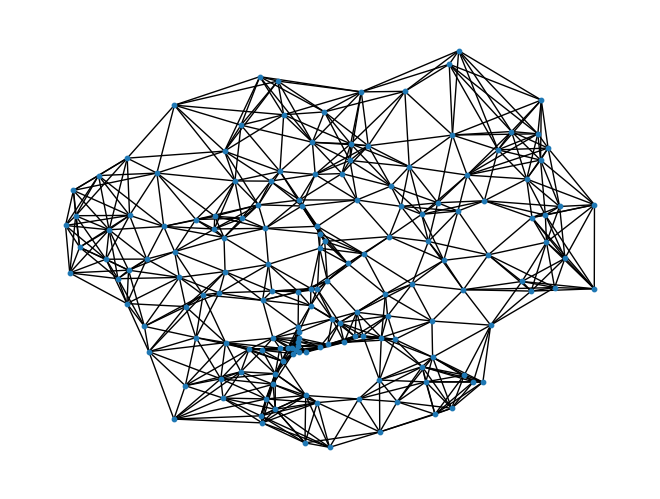

In [18]:
def distance_formula(x1, y1, x2, y2):
   dist = math.sqrt( (math.pow( (x1 - x2) ,2)) + (math.pow( (y1 - y2) ,2)) )
   return dist

def knn_edges(n, k, vertices):
    edges = []
    for key, v in vertices.items():
        # Values for x1,x2
        name = key
        y1 = v[0]
        x1 = v[1]

        # Calculate distances to other vertices
        distances = []
        for key2, u in vertices.items():
            if u[0]!=y1 and u[1]!=x1: 
                try:
                    distances.append((u, distance_formula(x1, y1, u[1], u[0])))
                except Exception as e:
                    print(f"Error calculating distance: {e}")
        
        # Sort distances
        distances.sort(key=lambda x: x[1])

        # Select k nearest neighbors and add edges
        for u, _ in distances[:k]:
            val = {i for i in martagraph if martagraph[i]==u}
            va = val.pop()
            edges.append((name, va))

    return edges

G = nx.Graph()

# Step 3: Add nodes and edges
for name, coordinates in martagraph.items():
    G.add_node(name, pos=coordinates)  # Add node with 'pos' attribute

edges = knn_edges(160, 8, martagraph)
print(edges)
G.add_edges_from(edges)

# Plot the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10)
plt.show()

In [19]:
for k in range(20):
    G = nx.Graph()

    # Step 3: Add nodes and edges
    for name, coordinates in martagraph.items():
        G.add_node(name, pos=coordinates)  # Add node with 'pos' attribute

    edges = knn_edges(160, k, martagraph)
    G.add_edges_from(edges)
    try: 
        eulerian_circuit = list(nx.eulerian_circuit(G))
        # Print the Eulerian circuit
        print("Eulerian Circuit:", eulerian_circuit)

        # Visualize the graph and the Eulerian circuit
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, font_weight='bold')
        nx.draw_networkx_edges(G, pos, edgelist=eulerian_circuit, edge_color='r', width=2)
        plt.show()
    except Exception as e:
        print(f"Error not Eulerian: {e}")

Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.
Error not Eulerian: G is not Eulerian.


In [20]:
'''def hamiltonian(graph, start, path=[]):
    path = path + [start]
    if len(path) == len(graph.nodes):
        return path
    for node in graph.neighbors(start):
        if node not in path:
            new_path = hamiltonian(graph, node, path)
            if new_path:
                return new_path
    return None

starting_node = list(G.nodes)[0]

hamiltonian_path = hamiltonian(graph=G, start=starting_node)

print("Hamiltonian Path:", hamiltonian_path)
'''
# Visualize the graph and the Hamiltonian path
'''
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
nx.draw_networkx_nodes(G, pos, nodelist=hamiltonian_path, node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=[(hamiltonian_path[i], hamiltonian_path[i + 1]) for i in range(len(hamiltonian_path) - 1)], edge_color='r', width=2)
plt.show()
'''

"\npos = nx.spring_layout(G)\nnx.draw(G, pos, with_labels=True, font_weight='bold')\nnx.draw_networkx_nodes(G, pos, nodelist=hamiltonian_path, node_color='r')\nnx.draw_networkx_edges(G, pos, edgelist=[(hamiltonian_path[i], hamiltonian_path[i + 1]) for i in range(len(hamiltonian_path) - 1)], edge_color='r', width=2)\nplt.show()\n"

Eulerian Circuit: [('Airport', 'Village Park'), ('Village Park', 'Lake Charlotte Preserve'), ('Lake Charlotte Preserve', 'Chapel Hill Park'), ('Chapel Hill Park', 'Kennedy Memorial Gardens'), ('Kennedy Memorial Gardens', 'Lake Charlotte Preserve'), ('Lake Charlotte Preserve', 'Browns Mill Park'), ('Browns Mill Park', 'Kennedy Memorial Gardens'), ('Kennedy Memorial Gardens', 'Village Park'), ('Village Park', 'Browns Mill Park'), ('Browns Mill Park', 'Chapel Hill Park'), ('Chapel Hill Park', 'Village Park'), ('Village Park', 'Exchange Park'), ('Exchange Park', 'Browns Mill Park'), ('Browns Mill Park', 'Deerwood Park'), ('Deerwood Park', 'Cascade Springs'), ('Cascade Springs', 'Woodrow Willson Park'), ('Woodrow Willson Park', 'Heritage Park'), ('Heritage Park', 'Palisades Unit'), ('Palisades Unit', 'Morgan Falls'), ('Morgan Falls', 'Sope Creek '), ('Sope Creek ', 'Palisades Unit'), ('Palisades Unit', 'Standing Peachtree Park'), ('Standing Peachtree Park', 'Heritage Park'), ('Heritage Park

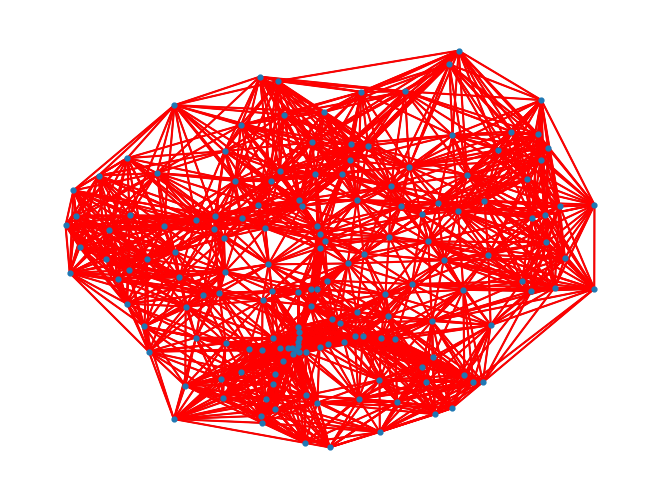

In [21]:
Ge = nx.euler.eulerize(G)

eulerian_circuit = list(nx.eulerian_circuit(Ge))

# Print the Eulerian circuit
print("Eulerian Circuit:", eulerian_circuit)

# Visualize the graph and the Eulerian circuit
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=12)
nx.draw_networkx_edges(Ge, pos, edgelist=eulerian_circuit, edge_color='r', width=1.5)
plt.show()

In [22]:
start = input("Enter your starting location: ")
end = input("Enter your destination: ")
print(nx.dijkstra_path(G, start, end))

['Dacula', 'Loganville', 'Collinsville', 'Exchange Park']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric

# Assuming you have an adjacency matrix as the input to the GNN
# Convert your NetworkX graph to a PyTorch Geometric Data object
data = torch_geometric.utils.from_networkx(G)

# Define and train a GNN model
class GNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GNN, self).__init__()
        self.conv1 = torch_geometric.nn.GraphConv(input_size, hidden_size)
        self.conv2 = torch_geometric.nn.GraphConv(hidden_size, output_size)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNN(input_size=..., hidden_size=..., output_size=...)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model on your graph data
for epoch in range(20):
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

# Use the learned embeddings to guide Hamiltonian path search
node_embeddings = model.conv1(data.x, data.edge_index)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple policy network for reinforcement learning
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Train the policy network on your custom environment
# ...

# Use the trained policy network to guide Hamiltonian path construction
policy_net = PolicyNetwork(input_size=..., hidden_size=..., output_size=...)
state = initialize_environment()  # Custom function to set up the environment
while not is_terminal(state):  # Custom function to check if the environment is in a terminal state
    action_probabilities = policy_net(state)
    selected_node = sample_action(action_probabilities)
    state = apply_action(state, selected_node)  # Custom function to apply the selected action

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b3686541-b591-45d5-90b4-564457237abf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>